## Visualizations of Chromium Emission in the US
## By Penny Xu
### Hexavalent chromium [Cr(VI)] is one of the valence states (+6) of the element chromium. It is usually produced by an industrial process. Cr(VI) is known to cause cancer, and is harmful to the eyes, skin, and respiratory system. Ingestion of Cr(VI) through drinking water has been found to cause cancer in the oral cavity and small intestine.
### In this article, the central interactive visualization displays the percent of Cr(VI) discharged by facilities in US states. And there are three contextual visualizations: overview of the above, overall and specific view of the distance to the receiving water body.

### Data Source: ProPublica analysis of the EPA’s Risk Screening Environmental Indicators model (https://www.propublica.org/datastore/dataset/toxic-air-pollution-hot-spots)
### Related Information Source: https://www.cdc.gov/niosh/topics/hexchrom/default.html https://en.wikipedia.org/wiki/Hexavalent_chromium

In [1]:
import bqplot 
from bqplot import pyplot as plt
from bqplot import Tooltip
import matplotlib.pyplot as matplt
import numpy as np
import ipywidgets
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import contextily as ctx

In [2]:
facilities = pd.read_csv('facilities_for_data_store.csv')

geometry = [Point(xy) for xy in zip(facilities['longitude'], facilities['latitude'])]
gdf_facilities = GeoDataFrame(facilities, geometry=geometry) 

In [3]:
chromhex_state = gdf_facilities.groupby('state')['chromhexpercent'].describe()

up_fig = plt.figure(title='Percent of Chromium in All States')

up_fig.layout.height = '580px'
up_fig.layout.width = '1000px'

bar_chart = plt.bar(chromhex_state.index.tolist(), chromhex_state['mean'].tolist(), 
                    interactions={'click':'select'}, selected_style={'fill':'magenta'})

bar_chart.colors = ['pink']

plt.xlabel('State')
plt.ylabel('Percent of Chromium')

In [4]:
out = ipywidgets.Output()

def hover_handler(self, content):
        out.clear_output()
        with out:
            print('City: ', state_data.iloc[content['data']['index']] ['city'], ',',
                  'Percent of Cr(VI):', state_data.iloc[content['data']['index']] ['chromhexpercent'])

In [5]:
state_data = gdf_facilities.loc[gdf_facilities['state'] == 'TX']

down_fig = plt.figure()

x_sc = plt.LinearScale()
y_sc = plt.LinearScale()

x_ax = plt.Axis(scale=x_sc, label='Longitude')
y_ax = plt.Axis(scale=y_sc, orientation='vertical', label='Latitude')

scatters =plt.scatter(x=state_data['longitude'], y=state_data['latitude'], 
                         scales={'x':x_sc, 'y':y_sc}, color=state_data['chromhexpercent'], cmap='RdPu', tooltip=out)
scatters.on_hover(hover_handler)

down_fig = plt.Figure(marks=[scatters], axes=[x_ax,y_ax], title='Percent of Chromium in One Slected State')
down_fig.layout.height = '580px'
down_fig.layout.width = '1000px'

In [6]:
def on_selected(change):
    state=''
    if change['owner'].selected != None:
        if len(change['owner'].selected) == 1: 
            state_index = change['owner'].selected[0]
            state = chromhex_state.index.tolist()[state_index]
    
    state_data = gdf_facilities.loc[gdf_facilities['state'] == state]
    scatters.x=state_data['longitude']
    scatters.y=state_data['latitude']

In [7]:
bar_chart.observe(on_selected, 'selected')
myLabel = ipywidgets.Label()
figures = ipywidgets.VBox([up_fig,down_fig])
myDashboard = ipywidgets.VBox([figures, myLabel])
myDashboard

### Central Interactive Visualization (Run all above cells to display):
### The dashboard shows the percents of Chromium in multiple dimesions, consisting of a bar plot and a scatter plot. Chromium is toxic, and higher percent means more toxicity in emission. The bar plot displays the average percents of Chromium in all US states. The scatter plot displays the percents of Chromium in all locations by latitude and longitude. The higher the percent is, the darker the point would be. It is interactive by putting the cursor on a point, and the specific percent would be shown. The two plots are linked, and the scatter plot of a state will be displayed if clicking the bar of the state in the bar plot.

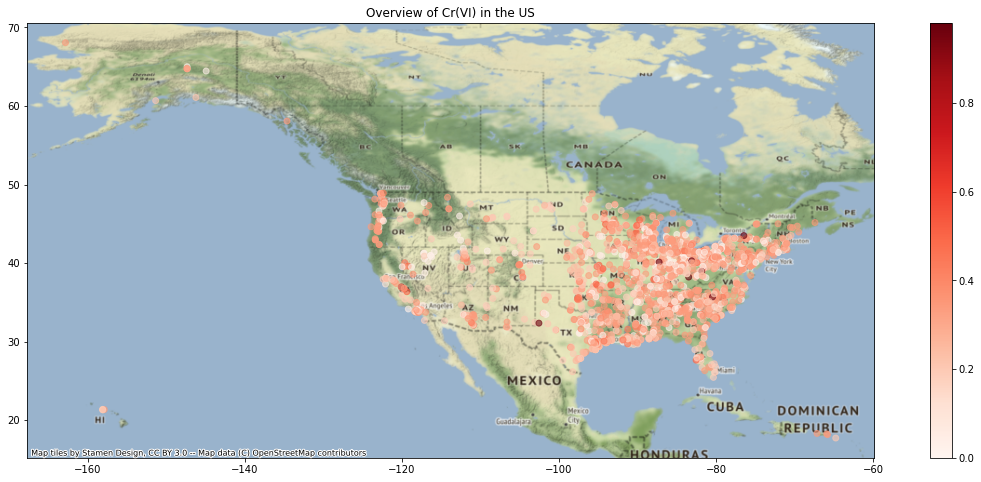

In [8]:
gdf_facilities.crs = 'EPSG:4326'
contextual_fig1, ax = matplt.subplots(figsize=(20, 8))

gdf_facilities.plot(ax=ax, column='chromhexpercent', cmap='Reds', legend=True, alpha=0.6)
matplt.title('Overview of Cr(VI) in the US')
ctx.add_basemap(ax=ax, crs=gdf_facilities.crs)
matplt.show()

### Contextual Visualization One:
### It displays the percent of Cr(VI) on the US map. The darker the scatter, the higher the percent. We can have a global understanding on facilities density and emissions in each state. Facilities are mainly concentrated in the east, central and west coasts, with percents concentrated at 0.2%-0.5%. Check the interactive visualization above  if you want to see specific data for a particular state.

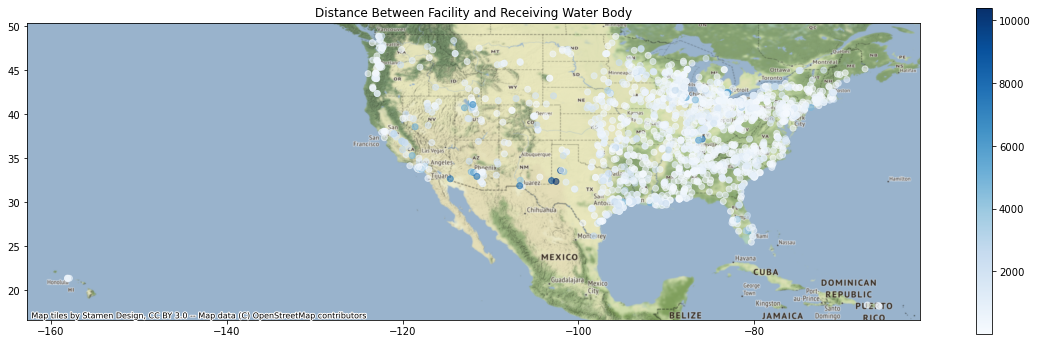

In [9]:
gdf_facilities.crs = 'EPSG:4326'
contextual_fig2, ax = matplt.subplots(figsize=(20, 6))

gdf_facilities.plot(ax=ax, column='distancetoreach', cmap='Blues', legend=True, alpha=0.6)
matplt.title('Distance Between Facility and Receiving Water Body')
ctx.add_basemap(ax=ax, crs=gdf_facilities.crs)
matplt.show()

### Contextual Visualization Two:
### Cr(VI) is present in drinking water and public water systems. It displays the distance between the facility discharging to water and the reach of the receiving water body in meters on the US map. The darker the scatter, the farther the distance is. Distances are concentrated under 2,000 meters. Check out the third visualization if you want to know more about the specific data by state.

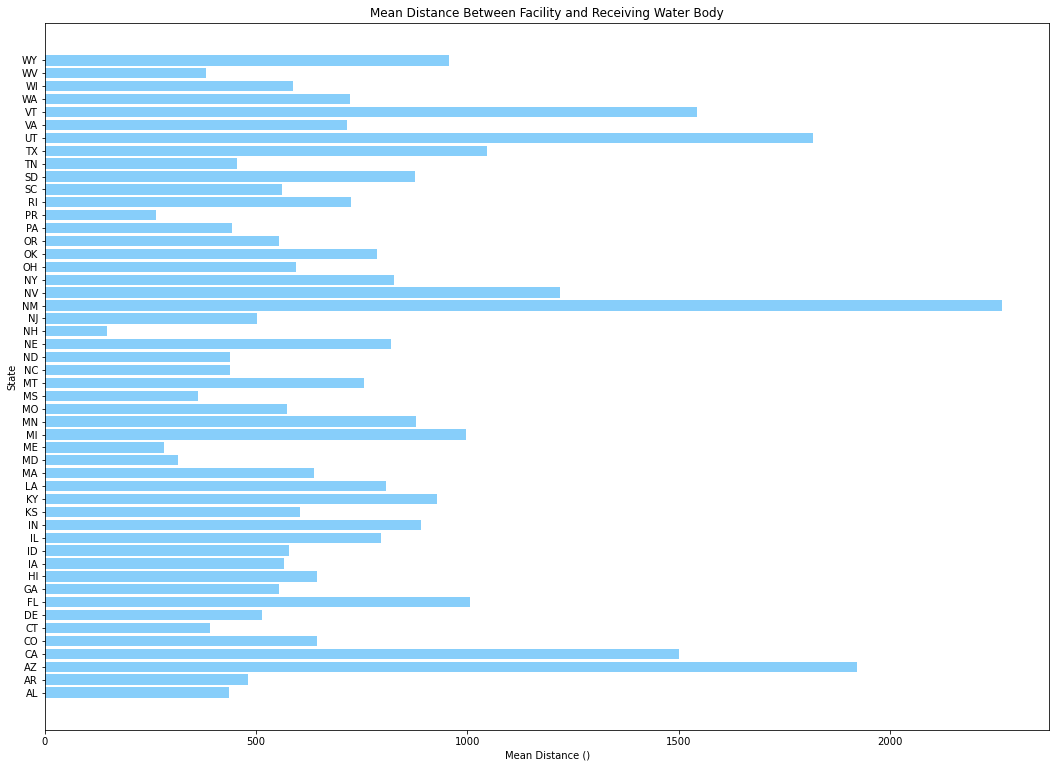

In [10]:
distance_state = gdf_facilities.loc[gdf_facilities['distancetoreach'].notnull()]
distance_state = distance_state.groupby('state')['distancetoreach'].describe()

contextual_fig3, ax = matplt.subplots(figsize=(18, 13))

matplt.barh(distance_state.index.tolist(), distance_state['mean'].tolist(), color='lightskyblue')
matplt.title('Mean Distance Between Facility and Receiving Water Body')
matplt.ylabel('State')
matplt.xlabel('Mean Distance ()')
matplt.show()

### Contextual Visualization Three:
### It displays the mean distance meationed above in US states. Longer distances mean less chance of water body being contaminated by Cr(VI). You can observe the visualization with the interactive visualization above, especially for states with short distrance, high Cr(VI) percent, and many facilities.